### Importing libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

/Users/chohi/project/ai/CapstonProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
def show_final_history(history):

    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [5]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):

#     np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

### Uploading the images

In [6]:
datasets = ['./SatelliteShips']

class_names = ["no-ship","ship"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

In [8]:
def load_data():
    images, labels = [], []

    for dataset in datasets:

        for folder in os.listdir(dataset):
            label = class_name_labels[folder]

            for file in tqdm(os.listdir(os.path.join(dataset,folder))):

                img_path = os.path.join(dataset,folder,file)

                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (48,48))

                images.append(img)
                labels.append(label)
                pass
            pass

        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass

    return (images, labels)
    pass

In [9]:
(images, labels) = load_data()
images.shape, labels.shape

100%|██████████| 1000/1000 [00:00<00:00, 2810.07it/s]


((4000, 48, 48, 3), (4000,))

### EDA of dataset

In [10]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
no-ship,3000
ship,1000


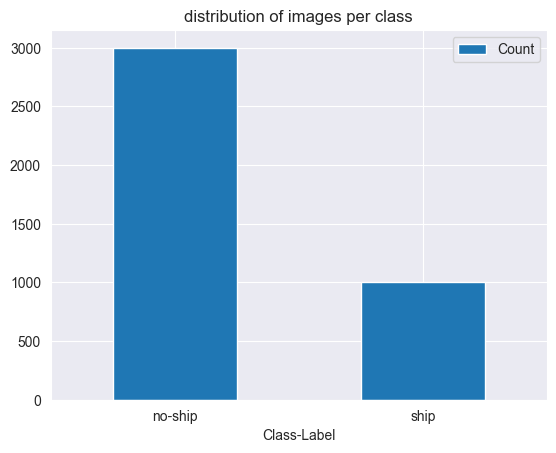

In [11]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

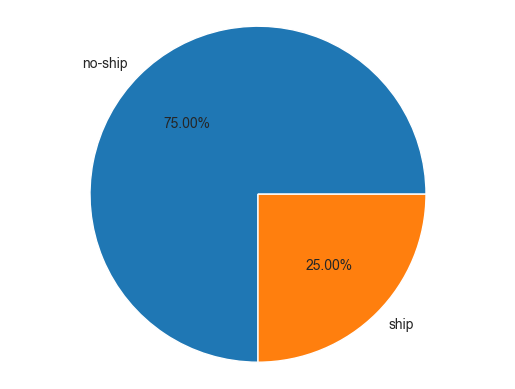

In [12]:
plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal');

### Augmenting Images of Minority Class

In [13]:
AUGMENTATION = True

In [14]:
def augment_add(images, seq, labels):

    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):

        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass

    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)

    return (augmented_images, augmented_labels)
    pass

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True)



In [16]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])

4000it [00:01, 3174.54it/s] 


In [17]:
images.shape, labels.shape

((6000, 48, 48, 3), (6000,))

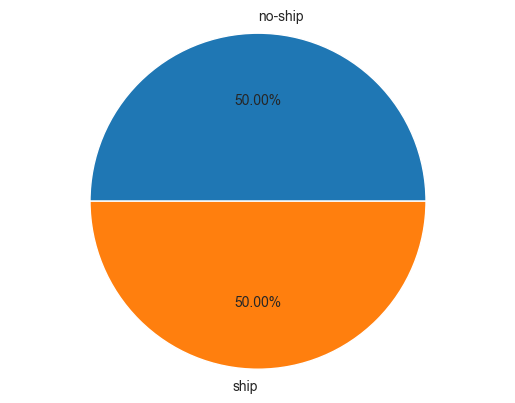

In [18]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True)

    plt.pie(count,
           explode=(0,0),
           labels=class_names,
           autopct="%1.2f%%")
    plt.axis('equal');

### One Hot Encoding Variables

In [19]:
labels = to_categorical(labels)

In [20]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

In [21]:
total_count = len(images)
total_count

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((4200, 48, 48, 3), (1200, 48, 48, 3), (600, 48, 48, 3))

In [22]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0)

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

In [23]:
def conv_block(X,k,filters,stage,block,s=2):

    conv_base_name = 'conv_' + str(stage)+block+'_branch'
    bn_base_name = 'bn_'+str(stage)+block+"_branch"

    F1 = filters

    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same',name=conv_base_name+'2a')(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)

    return X
    pass

In [24]:
def basic_model(input_shape,classes):

    X_input = Input(input_shape)

    X = ZeroPadding2D((5,5))(X_input)

    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X)
    X = BatchNormalization(name='bn_conv1')(X)

    # stage 2
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 3
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 4
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#   Output Layer
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Dropout(0.5)(X)

    X = Dense(128)(X)
    X = Activation("relu")(X)

    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC')

    return model
    pass

In [25]:
model = basic_model(input_shape=(48,48,3),classes=2)

In [26]:
plot_model(model,to_file='basic_model.png')
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

Model: "Feature_Extraction_and_FC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 58, 58, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 29, 29, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 29, 29, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2A_branch2a (Conv2D)       │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2A_branch2a                  │ (None, 29, 29, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3A_branch2a (Conv2D)       │ (None, 7, 7, 32)       │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3A_branch2a                  │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4A_branch2a (Conv2D)       │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4A_branch2a                  │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 62,530 (244.26 KB)

 Trainable params: 62,242 (243.13 KB)

 Non-trainable params: 288 (1.12 KB)

### Compiling the Model

In [31]:
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

In [33]:
epochs = 50
batch_size = 16

history = model.fit(train_images,train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(val_images,val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs]
#                    class_weight=classWeight # Uncomment if AUGMENTATION is set to FALSE
                   )

Epoch 1/50
248/262 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7844 - loss: 0.4822

/Users/chohi/project/ai/CapstonProject/.venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.08000, saving model to model_weights.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7872 - loss: 0.4764 - val_accuracy: 0.0800 - val_loss: 1.7444
Epoch 2/50
246/262 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9179 - loss: 0.2149
Epoch 2: val_accuracy improved from 0.08000 to 0.86917, saving model to model_weights.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9184 - loss: 0.2136 - val_accuracy: 0.8692 - val_loss: 0.3070
Epoch 3/50
243/262 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9340 - loss: 0.1843
Epoch 3: val_accuracy improved from 0.86917 to 0.95500, saving model to model_weights.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9345 - loss: 0.1826 - val_accuracy: 0.9550 - val_loss: 0.1216
Epoch 4/50
244/262 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9456 - loss: 0.1388
Epoch 4: val_accuracy did not improve from 0.95500
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9464 - loss: 0.1371 - val_accuracy: 0.8933 - val_loss: 0.3279
Epoch 5/50
248/262 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9626 - loss: 0.0962
Epoch 5: val_accuracy improved from 0.95500 to 0.97417, saving model to model_weights.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9626 - loss: 0.0964 - val_accuracy: 0.9742 - val_loss: 0.0862
Epoch 6/50
245/262 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9696 - loss: 0.0770
Epoch 6: val_accuracy did not improve from 0.97417
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9697 - loss: 0.0769 - val_accuracy: 0.9500 - val_loss: 0.1670
Epoch 7/50
245/262 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9725 - loss: 0.0752
Epoch 7: val_accuracy did not improve from 0.97417
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9728 - loss: 0.0747 - val_accuracy: 0.9625 - val_loss: 0.1115
Epoch 8/50
245/262 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9789 - loss: 0.0558
Epoch 8: val_accuracy did not improve from 0.97417
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9789 - loss: 0.0559 - val_accuracy: 0.9283 - val_loss: 0.2299
Epoch 9/50
243/262 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9821 - loss: 0.0534
Epoch 9: val_accuracy did n

262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9868 - loss: 0.0446 - val_accuracy: 0.9792 - val_loss: 0.0737
Epoch 16/50
246/262 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9837 - loss: 0.0502
Epoch 16: val_accuracy did not improve from 0.97917
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9838 - loss: 0.0500 - val_accuracy: 0.9692 - val_loss: 0.1120
Epoch 17/50
245/262 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9855 - loss: 0.0373
Epoch 17: val_accuracy did not improve from 0.97917
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9856 - loss: 0.0374 - val_accuracy: 0.9533 - val_loss: 0.1626
Epoch 18/50
247/262 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9862 - loss: 0.0465
Epoch 18: val_accuracy improved from 0.97917 to 0.98417, saving model to model_weights.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9864 - loss: 0.0457 - val_accuracy: 0.9842 - val_loss: 0.0732
Epoch 19/50
247/262 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9908 - loss: 0.0261
Epoch 19: val_accuracy did not improve from 0.98417
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9906 - loss: 0.0266 - val_accuracy: 0.9367 - val_loss: 0.2151
Epoch 20/50
244/262 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9892 - loss: 0.0282
Epoch 20: val_accuracy did not improve from 0.98417
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9893 - loss: 0.0279 - val_accuracy: 0.9408 - val_loss: 0.2314
Epoch 21/50
246/262 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9815 - loss: 0.0473
Epoch 21: val_accuracy did not improve from 0.98417
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9818 - loss: 0.0466 - val_accuracy: 0.9675 - val_loss: 0.1135
Epoch 22/50
243/262 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9743 - loss: 0.0732
Epoch 22: val_accura

### Plotting Loss and Accuracy

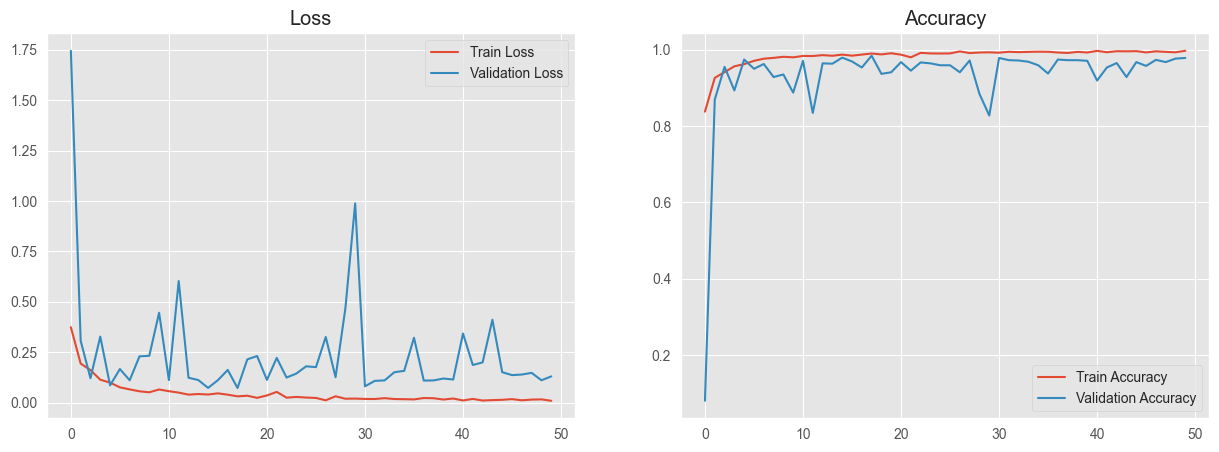

In [34]:
show_final_history(history)

### Confusion Matrix for Validation dataset

In [35]:
val_pred = model.predict(val_images)
val_pred = np.argmax(val_pred,axis=1)
val_pred.shape

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


(1200,)

/var/folders/8l/dq9nhgmx5gj01xrwhwzb41s40000gn/T/ipykernel_6663/874616278.py:4: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]


<Figure size 640x480 with 0 Axes>

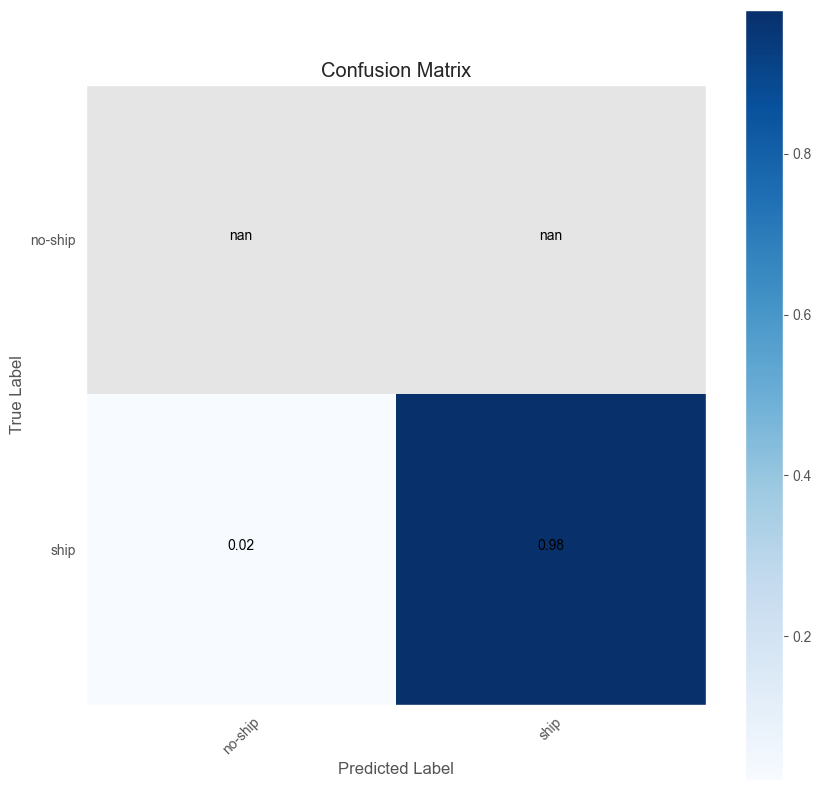

In [36]:
val_actual = np.argmax(val_labels,axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

### Confusion Matrix for Testing Dataset

In [37]:
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


(600,)

/var/folders/8l/dq9nhgmx5gj01xrwhwzb41s40000gn/T/ipykernel_6663/874616278.py:4: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]


<Figure size 640x480 with 0 Axes>

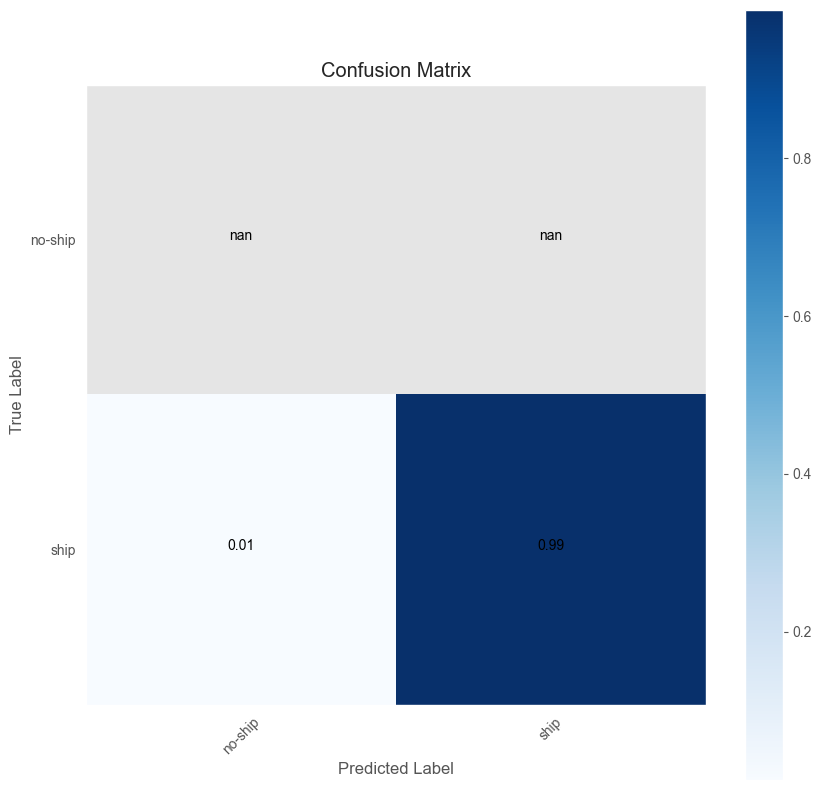

In [38]:
test_actual = np.argmax(test_labels,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()

### Checking the model

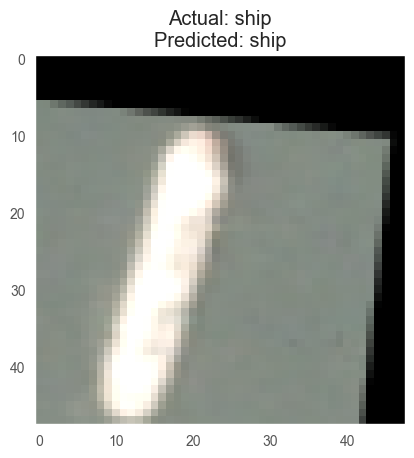

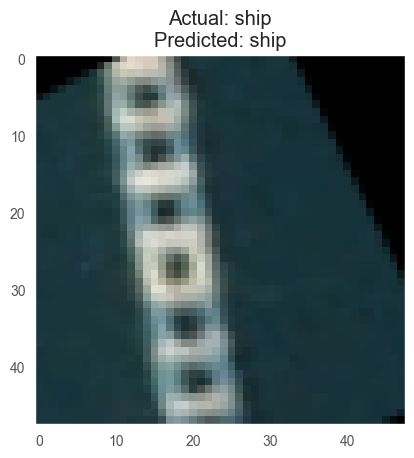

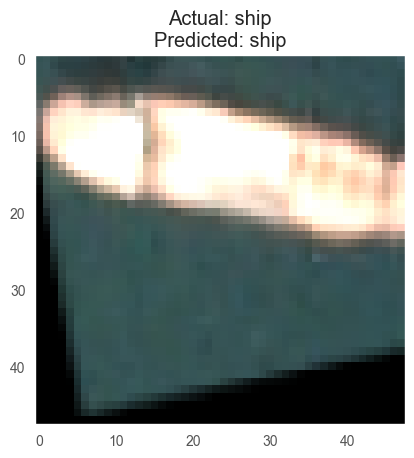

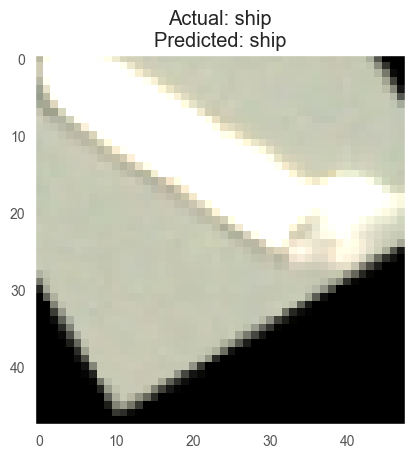

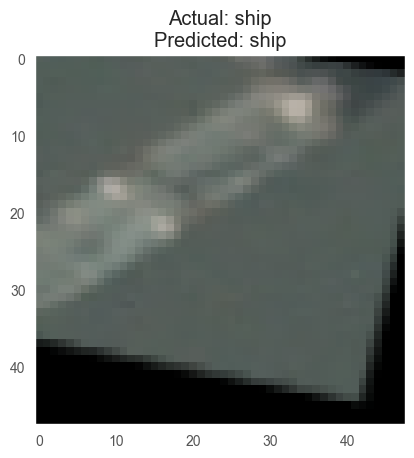

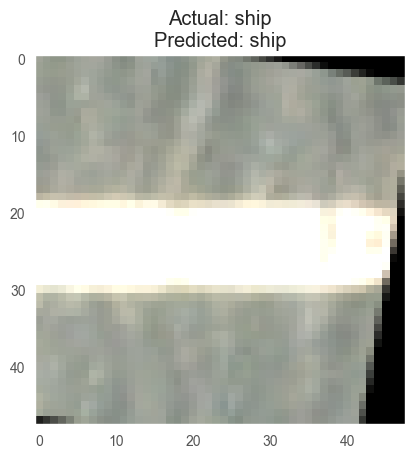

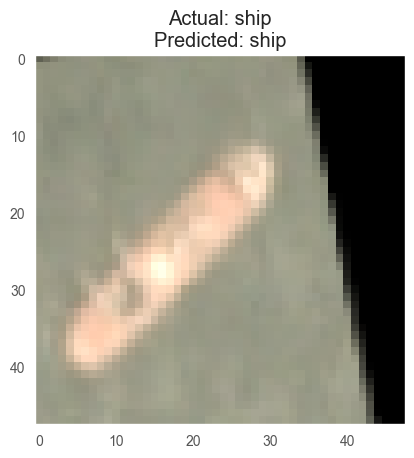

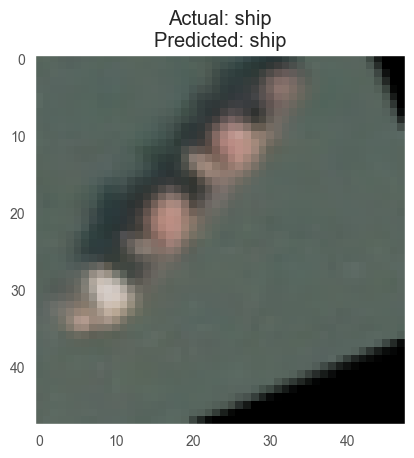

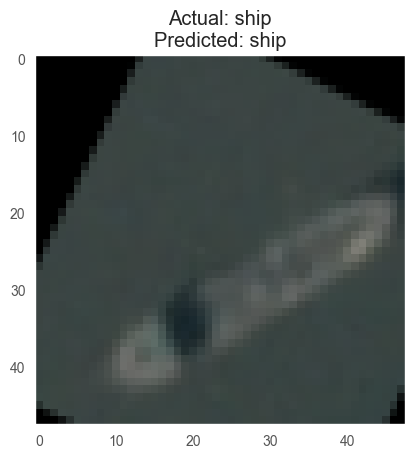

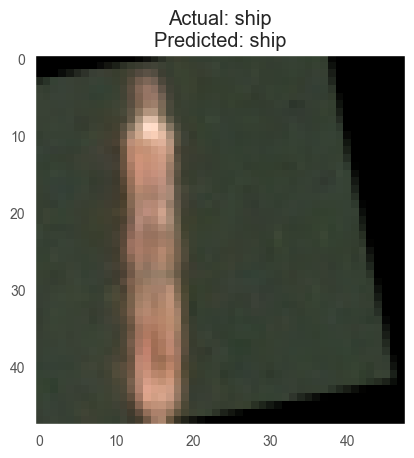

In [39]:
rnd_idx = random.sample(range(0,400),10)

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):

    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass

### saving the model

In [40]:
model.save("ship-model.h5")